In [0]:
!ls

sample_data


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp drive/My\ Drive/deceptive-opinion-spam-corpus.zip .
!unzip deceptive-opinion-spam-corpus.zip

Archive:  deceptive-opinion-spam-corpus.zip
  inflating: deceptive-opinion.csv   


In [0]:
!cp drive/My\ Drive/model.h5 .

In [0]:
import numpy as np 
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, BatchNormalization, Dropout, Reshape
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import keras
from sklearn.utils import resample

from keras.layers import Activation, Conv1D, Conv2D, Bidirectional, GlobalMaxPool1D
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, MaxPooling1D
from keras.layers import Bidirectional, Concatenate, Permute, Dot, LSTM, Multiply, Flatten
from keras.layers import RepeatVector, Activation
from keras.layers import BatchNormalization
from keras.models import Sequential, Model
from keras import backend as K
from keras.layers.embeddings import Embedding
from keras.models import load_model
from keras import optimizers as opt
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, Callback
from sklearn.metrics import roc_auc_score

pd.options.display.max_rows = 10
pd.options.display.max_columns = 15
from IPython.display import display



import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib as mplt
import os
import seaborn as sns
import tqdm

Using TensorFlow backend.


In [0]:
data = pd.read_csv('deceptive-opinion.csv')
# Keeping only the neccessary columns
data = data[['text','deceptive']]
data.head(1)
data = data.sample(frac=1)
data = data.sample(frac=1)
data = data.sample(frac=1)

data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))


data = data.replace(['truthful', 'deceptive'], [1, 0])
print(len(data[ data['deceptive'] == 1]))
print(len(data[ data['deceptive'] == 0]))

800
800


In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
embed = hub.Module(module_url)
tf.logging.set_verbosity(tf.logging.ERROR)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
Instructions for updating:
Colocations handled automatically by placer.


In [0]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), 
    	signature="default", as_dict=True)["default"]

def model_cdac(embed_size = 512):
    input_text = Input(shape=(1,), dtype=tf.string, name='input1')
#     print(keras.backend.shape(input_text))
    
    
    embedding = Lambda(UniversalEmbedding, output_shape=(embed_size,), name='embed1')(input_text)
    
    dense = Dense(512, activation='relu', name='dense1')(embedding)
    dense = Dense(256, activation='relu', name='dense2')(dense)
    dense = Dense(256, activation='relu', name='dense3')(dense)
#     dense = Dense(24, activation='relu', name='dense4')(dense)
    pred = Dense(2, activation='softmax', name='dense4')(dense)
    model = Model(inputs=[input_text], outputs=pred)
    model.compile(loss='categorical_crossentropy', 
    optimizer=opt.Adam(lr=0.0001, decay=1e-5), metrics=['accuracy'])
    return model

In [0]:
Y_train = pd.get_dummies(data['deceptive']).values

X_train = data['text'].tolist()
X_train = np.array(X_train, dtype=object)[:, np.newaxis]

In [0]:

# model = load_model('model.h5')
# model = model_cdac()
# model.load_weights('model.h5')
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model = model_cdac()
    history = model.fit(X_train, 
            Y_train,
            validation_split=0.07,
            epochs=13,
            batch_size=32)
    model.save_weights('./model.h5')

Train on 1488 samples, validate on 112 samples
Epoch 1/13
1488/1488 [==============================] - 11s 7ms/step - loss: 0.6778 - acc: 0.6472 - val_loss: 0.6501 - val_acc: 0.7500
Epoch 2/13
1488/1488 [==============================] - 7s 5ms/step - loss: 0.6164 - acc: 0.7339 - val_loss: 0.5545 - val_acc: 0.7768
Epoch 3/13
1488/1488 [==============================] - 7s 5ms/step - loss: 0.5325 - acc: 0.7520 - val_loss: 0.4750 - val_acc: 0.7857
Epoch 4/13
1488/1488 [==============================] - 7s 5ms/step - loss: 0.4777 - acc: 0.7796 - val_loss: 0.4821 - val_acc: 0.7679
Epoch 5/13
1488/1488 [==============================] - 7s 5ms/step - loss: 0.4526 - acc: 0.7897 - val_loss: 0.4372 - val_acc: 0.7946
Epoch 6/13
1488/1488 [==============================] - 7s 5ms/step - loss: 0.4239 - acc: 0.8058 - val_loss: 0.4127 - val_acc: 0.8214
Epoch 7/13
1488/1488 [==============================] - 7s 5ms/step - loss: 0.3991 - acc: 0.8233 - val_loss: 0.4071 - val_acc: 0.8304
Epoch 8/13
148

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

from google.colab import files
files.download('model.png')

In [0]:
with tf.Session() as session: 
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    layer_name = 'dense3'
    model = model_cdac()
    model.load_weights('./model.h5')
    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=model.get_layer(layer_name).output)
    intermediate_output = intermediate_layer_model.predict(X_train, verbose=1)

1600/1600 [==============================] - 8s 5ms/step


In [0]:
print(intermediate_output.shape)

(1600, 256)


In [0]:
import time

from sklearn.manifold import TSNE

n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(intermediate_output)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.017s...
[t-SNE] Computed neighbors for 1600 samples in 0.576s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 0.148155
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.253078
[t-SNE] KL divergence after 300 iterations: 0.999630
t-SNE done! Time elapsed: 4.659975051879883 seconds


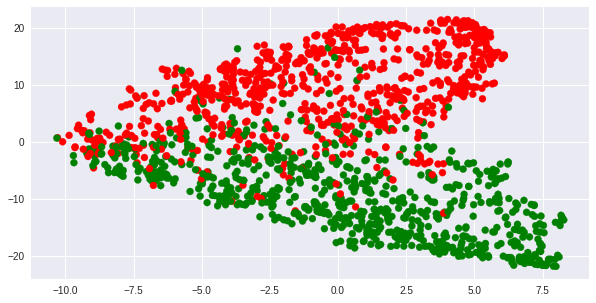

In [0]:
plt.figure(figsize=(10, 5))
colors = ['red','green']
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=data['deceptive'].values, cmap=mplt.colors.ListedColormap(colors))

In [0]:
!cp model.h5 drive/My\ Drive/

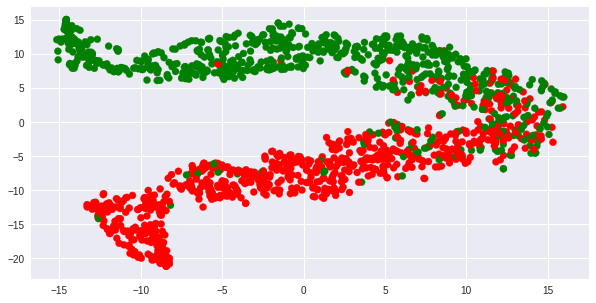

In [0]:
plt.figure(figsize=(10, 5))
colors = ['red','green']
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=data['deceptive'].values, cmap=mplt.colors.ListedColormap(colors))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input1 (InputLayer)          (None, 1)                 0         
_________________________________________________________________
embed1 (Lambda)              (None, 512)               0         
_________________________________________________________________
dense1 (Dense)               (None, 512)               262656    
_________________________________________________________________
dense2 (Dense)               (None, 256)               131328    
_________________________________________________________________
dense3 (Dense)               (None, 256)               65792     
_________________________________________________________________
dense4 (Dense)               (None, 2)                 514       
Total params: 460,290
Trainable params: 460,290
Non-trainable params: 0
_________________________________________________________________
